In [1]:
# import modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as PathEffects
from matplotlib.colors import LogNorm
from matplotlib.cm import get_cmap

# set matplotlib variables
mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
mpl.rcParams['legend.fontsize'] = 22
mpl.rcParams['axes.labelsize'] = 22
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['text.latex.preamble'] = r'\usepackage[T1]{fontenc}'

In [2]:
def dist_cdf(dist, edges):
    delta = edges[1:] - edges[:-1]
    return np.cumsum(dist*delta)

yes 68
yes 95
yes 99
0.9901247806342045
0.9500465416232501
0.680038373098905
The mode is: k=0.18, r=0.1120
68% confidence interval for k: 0.11-0.27
95% confidence interval for k: 0.08-0.42
99% confidence interval for k: 0.06-0.55
68% confidence interval for r: 0.10-0.93
95% confidence interval for r: 0.03-5.90
99% confidence interval for r: 0.01-27.63


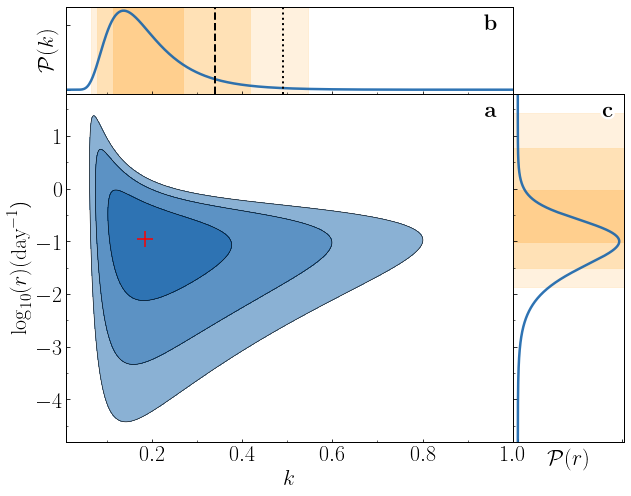

In [3]:
if __name__=="__main__":
    # dataset containing Wb and Onsala L-band observations which do not overlap.
    data = np.load("wb_onsala_post.npy", allow_pickle=True)
    
    post = data[0]
    k = data[1]
    r = data[2]

    kstart = k[0]
    kstop = k[-1]
    rstart = np.log10(r[0])
    rstop = np.log10(r[-1])

    k_cent = 0.5*(k[1:] + k[:-1])
    r_cent = 10**(0.5*(np.log10(r[1:]) + np.log10(r[:-1])))

    km, rm = np.meshgrid(k_cent, r_cent)

    k_delta = k[1:] - k[:-1]
    r_delta = r[1:] - r[:-1]

    kd_mesh, rd_mesh = np.meshgrid(k_delta, r_delta)


    # find marginal distribution of k
    k_marg = np.sum(post*rd_mesh, axis=0)

    # calculate cumulative distribution function of k
    k_c = dist_cdf(k_marg, k)

    # k median
    k_med = k[np.where(k_c>=0.5)[0][0]]

    # find marginal distribution of r
    r_marg = np.sum(post*kd_mesh, axis=1)

    # calculate cumulative distribution function of r
    r_c = dist_cdf(r_marg, r)

    # r median
    r_med = np.log10(r[np.where(r_c>=0.5)[0][0]])

    # calculate confidence intervals from cdf's
    k_99low = k_cent[np.where(k_c>=0.005)[0][0]]
    k_99high = k_cent[np.where(k_c>= 0.995)[0][0]]

    r_99low = np.log10(r_cent[np.where(r_c>=0.005)[0][0]])
    r_99high = np.log10(r_cent[np.where(r_c>=0.995)[0][0]])

    k_68low = k_cent[np.where(k_c>=0.16)[0][0]]
    k_68high = k_cent[np.where(k_c>=0.84)[0][0]]

    r_68low = np.log10(r_cent[np.where(r_c>=0.16)[0][0]])
    r_68high = np.log10(r_cent[np.where(r_c>=0.84)[0][0]])

    k_95low = k_cent[np.where(k_c>=0.025)[0][0]]
    k_95high = k_cent[np.where(k_c>=0.975)[0][0]]

    r_95low = np.log10(r_cent[np.where(r_c>=0.025)[0][0]])
    r_95high = np.log10(r_cent[np.where(r_c>=0.975)[0][0]])

    # calculate modes of marginal distribution
    k_mode = k_cent[np.where(k_marg==np.max(k_marg))[0][0]]
    r_mode = np.log10(r_cent[np.where(r_marg==np.max(r_marg))[0][0]])

    # create array of points (in units of max of distribution) to find confidence regions
    points = np.linspace(1, 0.0001, 1000)

    conf_regions = []
    flag68 = False
    flag95 = False
    flag99 = False
    # find 68%, 95%, and 99% confidence regions of joint distribution
    for i, point in enumerate(points):
        where = np.where(post>=point*np.max(post))
        val = np.sum(post[where]*kd_mesh[where]*rd_mesh[where])
        if (val >= 0.68) and not flag68:

            #refine point corresponding to confidence region
            for num in np.linspace(points[i-1], points[i]):
                where = np.where(post>=num*np.max(post)) 
                newval = np.sum(post[where]*kd_mesh[where]*rd_mesh[where])
                if (newval >= 0.68):
                    print("yes 68")
                    conf_regions.append(num*np.max(post))
                    flag68 = True
                    break
        elif (val>=0.95) and not flag95:

            #refine point corresponding to confidence region
            for num in np.linspace(points[i-1], points[i]):
                where = np.where(post>=num*np.max(post)) 
                newval = np.sum(post[where]*kd_mesh[where]*rd_mesh[where])
                if (newval >= 0.95):
                    print("yes 95")
                    conf_regions.append(num*np.max(post))
                    flag95 = True
                    break
        elif (val>=0.99) and not flag99:
            #refine point corresponding to confidence region
            for num in np.linspace(points[i-1], points[i]):
                where = np.where(post>=num*np.max(post)) 
                newval = np.sum(post[where]*kd_mesh[where]*rd_mesh[where])
                if (newval >= 0.99):
                    print("yes 99")
                    conf_regions.append(num*np.max(post))
                    flag99 = True
                    break
            break

    conf_regions = np.array(conf_regions)

    conf_regions = conf_regions[::-1]

    for conf in conf_regions:
        where = np.where(post>=conf)
        print(np.sum(post[where]*kd_mesh[where]*rd_mesh[where]))

    # create figure
    fig = plt.figure(figsize=(10, 8)) 
    rows=2
    cols=2
    widths = [4, 1]
    heights = [1, 4]
    gs = fig.add_gridspec(ncols=cols, nrows=rows, width_ratios=widths, height_ratios=heights, wspace=0., hspace=0.)
    
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[0,0])
    ax3 = fig.add_subplot(gs[1,1])
    
    cmap = get_cmap('Blues')
    color = cmap(0.8)

    low = (color[0], color[1], color[2], 0.5)
    mid = (color[0], color[1], color[2], 0.7)
    high = (color[0], color[1], color[2], 0.9)

    cs = ax1.contourf(km, np.log10(rm), post, 
                levels=conf_regions, extend='max',colors=[low, mid, high])
    ax1.contour(cs, colors='k', linewidths=0.6, antialiased=True)

    where_max = np.where(post==np.max(post))

    ax1.scatter(km[where_max], np.log10(rm[where_max]), s=280, marker="+", color="r")

    ylim_min, ylim_max = -4.8, 1.80
    
    print("The mode is: k={:0.2f}, r={:0.4f}".format(km[where_max][0], rm[where_max][0]))
    ax1.set_ylim(ylim_min, ylim_max)
    ax1.set_xlim(kstart, 1)
    ax1.set_ylabel(r"$\log_{10}(r) (\textrm{day}^{-1}$)")
    ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax1.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_xticklabels([r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'])
    ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax1.set_xlabel("$k$")
    ax1.tick_params(axis='both', which='both', direction='in')

    ax2.plot(k_cent, k_marg, color=high, lw=2.5)
    ax2.axvspan(k_99low, k_99high, alpha=0.4, color='navajowhite')
    ax2.axvspan(k_68low, k_68high, alpha=0.9, color='darkorange')
    ax2.axvspan(k_95low, k_95high, alpha=0.8, color='navajowhite')
    ax2.set_ylabel("$\mathcal{P}(k)$")
    ax2.set_xlim(kstart, 1)
    ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax2.set_xticklabels([r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1.0$'])
    ax2.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.tick_params(axis='both', which='both', direction='in')
    
    # most likely values from Opperman et al. and Oostrum et al.
    # see Kirsten et al. 2020 for details.
    ax2.axvline(0.34, ls="--", c="k", lw=2)
    ax2.axvline(0.49, ls=":", c="k", lw=2)

    print("68% confidence interval for k: {:0.2f}-{:0.2f}".format(k_68low, k_68high))
    print("95% confidence interval for k: {:0.2f}-{:0.2f}".format(k_95low, k_95high))
    print("99% confidence interval for k: {:0.2f}-{:0.2f}".format(k_99low, k_99high))
    
    print("68% confidence interval for r: {:0.2f}-{:0.2f}".format(10**r_68low, 10**r_68high))
    print("95% confidence interval for r: {:0.2f}-{:0.2f}".format(10**r_95low, 10**r_95high))
    print("99% confidence interval for r: {:0.2f}-{:0.2f}".format(10**r_99low, 10**r_99high))

    ax3.plot(r_marg, np.log10(r_cent), color=high, lw=2.5)
    ax3.axhspan(r_99low, r_99high, alpha=0.4, color='navajowhite')
    ax3.axhspan(r_68low, r_68high, alpha=0.9, color='darkorange')
    ax3.axhspan(r_95low, r_95high, alpha=0.8, color='navajowhite')
    
    ax3.set_ylim(ylim_min, ylim_max)
    ax3.set_xticklabels([])
    ax3.set_xlabel("$\mathcal{P}(r)$")
    ax3.set_yticklabels([])
    ax3.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax3.tick_params(axis='both', which='both', direction='in')
    
    txtax1 = ax1.text(0.95, 0.95, (r'${\rm {\bf %s}}$')%'a', ha='center', va='center', transform = ax1.transAxes)
    txtax1.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    
    txtax2 = ax2.text(0.95, 0.80, (r'${\rm {\bf %s}}$')%'b', ha='center', va='center', transform = ax2.transAxes)
    txtax2.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    
    txtax3 = ax3.text(0.85, 0.95, (r'${\rm {\bf %s}}$')%'c', ha='center', va='center', transform = ax3.transAxes)
    txtax3.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
     
    plt.savefig('weibull.pdf', bbox_inches='tight', dpi=1200)
    plt.show()